### NBodySystem

In [2]:
# include("utils/nbodysystem.jl")
# include("tests/nbodysystem-test.jl")

# num_steps = 2000
# dt = 10000.0
# test_nbody_system(num_steps, dt)

### Center initial state

In [3]:
# test_center_initial_state()

### NBodyEnvironment()

In [4]:
# include("utils/nbodyenvironment.jl")
# include("tests/nbodyenvironment-test.jl")

# test_nbody_environment()

### Scaler

In [5]:
# include("utils/scaler.jl")
# include("tests/scaler-test.jl")

# test_buildscaler_nbody()

### Agent Training Loop

Importing utils...


Done importing. Starting run...
Expected number of steps per episode: 231
Building scaler...


Scaler built!


Episode 1 | Global Step 490 | Total Reward 744.081 | Avg Reward 1.519 | Avg State Error-Tol 0.641 | Avg Energy Error-Tol 0.968 | Avg State Reward 1.585 | Avg Energy Reward 0.923


Episode 2 | Global Step 956 | Total Reward 757.419 | Avg Reward 1.625 | Avg State Error-Tol 0.646 | Avg Energy Error-Tol 1.018 | Avg State Reward 1.696 | Avg Energy Reward 0.987


Episode 3 | Global Step 1427 | Total Reward 785.679 | Avg Reward 1.668 | Avg State Error-Tol 0.613 | Avg Energy Error-Tol 1.009 | Avg State Reward 1.741 | Avg Energy Reward 1.01


Episode 4 | Global Step 1895 | Total Reward 721.574 | Avg Reward 1.542 | Avg State Error-Tol 0.634 | Avg Energy Error-Tol 1.016 | Avg State Reward 1.605 | Avg Energy Reward 0.971


Episode 5 | Global Step 2358 | Total Reward 769.419 | Avg Reward 1.662 | Avg State Error-Tol 0.68 | Avg Energy Error-Tol 1.025 | Avg State Reward 1.736 | Avg Energy Reward 0.996


Episode 6 | Global Step 2814 | Total Reward 708.474 | Avg Reward 1.554 | Avg State Error-Tol 0.706 | Avg Energy Error-Tol 1.042 | Avg State Reward 1.611 | Avg Energy Reward 1.034


Episode 7 | Global Step 3273 | Total Reward 693.263 | Avg Reward 1.51 | Avg State Error-Tol 0.702 | Avg Energy Error-Tol 1.036 | Avg State Reward 1.566 | Avg Energy Reward 1.008


Episode 8 | Global Step 3734 | Total Reward 769.216 | Avg Reward 1.669 | Avg State Error-Tol 0.628 | Avg Energy Error-Tol 1.03 | Avg State Reward 1.741 | Avg Energy Reward 1.017


Episode 9 | Global Step 4195 | Total Reward 737.254 | Avg Reward 1.599 | Avg State Error-Tol 0.675 | Avg Energy Error-Tol 1.03 | Avg State Reward 1.669 | Avg Energy Reward 0.971


Episode 10 | Global Step 4655 | Total Reward 720.215 | Avg Reward 1.566 | Avg State Error-Tol 0.667 | Avg Energy Error-Tol 1.033 | Avg State Reward 1.628 | Avg Energy Reward 1.001

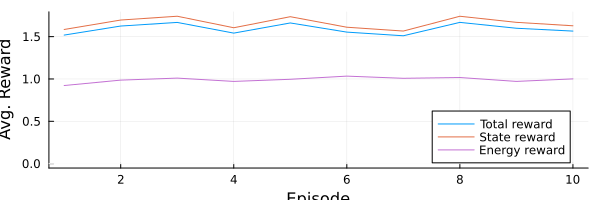

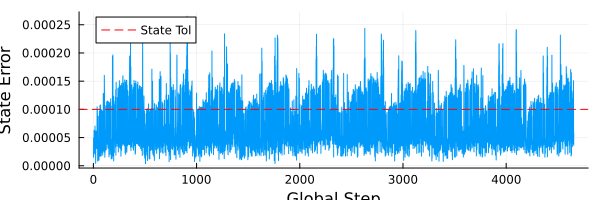

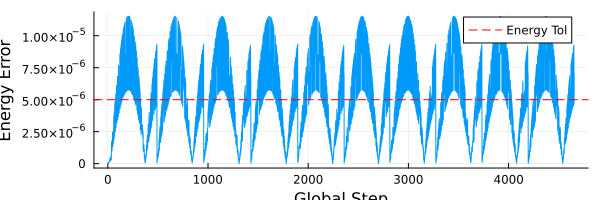

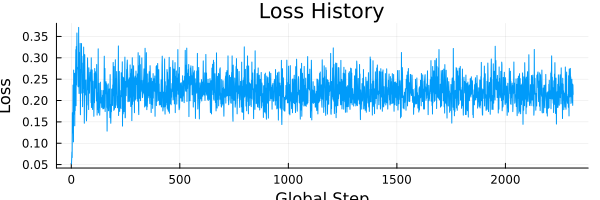

In [6]:
println("Importing utils...")

using Flux
using Random
include("utils/nbodysystem.jl")
include("utils/nbodyenvironment.jl")
include("utils/scaler.jl")
include("utils/agent.jl")

println("Done importing. Starting run...")

# Define constants
N_EPISODES = 10
MAX_TIME = 5e6
ACTION_SPACE = map(x -> x * 3600, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])

METHOD = "RKDP"                 # Agent's integrator, used to calculate estimated next state
MEMORY_SIZE = 10000             # Numer of consecutive past observations available for experience replay
LOOKBACK = 2                    # Number of consecutive observations observed by agent
STATE_TOL = 1e-4               # Tolerance for state error (normalized, stepwise)
ENERGY_TOL = 5e-6               # Tolerance for energy conservation (normalized, stepwise)
ALPHA = 0.9                     # Weighting for state reward
POS_REWARD_RANGE = (0.1, 5.0)   # Range of positive rewards (state and energy reward calculated separately and added)
BATCH_SIZE = 32             
LEARNING_RATE = 1e-4
GAMMA = 0.2                     # Discount factor for future rewards (0 = future rewards don't matter)
EPSILON = 0.5                   # Probability of not choosing the best action (0 = greedy, 1 = random)
UPDATE_FREQ = 2                 # Number of global steps between each training step

GRAVITY = 6.67430e-11
INITIAL_STATE = [
    Body(1.989e30, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]),              # Sun
    Body(0.33011e24, [57.909e9, 0.0, 0.0], [0.0, 47.36e3, 0.0], [0.0, 0.0, 0.0]),    # Mercury
    Body(4.8675e24, [108.208e9, 0.0, 0.0], [0.0, 35.02e3, 0.0], [0.0, 0.0, 0.0]),   # Venus
    Body(5.972e24, [149.6e9, 0.0, 0.0], [0.0, 29.78e3, 0.0], [0.0, 0.0, 0.0]),      # Earth
    # Body(7.34767309e22, [149.6e9 + 384400000.0, 0.0, 0.0], [0.0, 29.78e3 + 1022.0, 0.0], [0.0, 0.0, 0.0]), # Moon
    Body(0.64171e24, [227.9e9, 0.0, 0.0], [0.0, 24.13e3, 0.0], [0.0, 0.0, 0.0]),    # Mars
    # Body(1898.13e24, [778.57e9, 0.0, 0.0], [0.0, 13.07e3, 0.0], [0.0, 0.0, 0.0]),   # Jupiter
    # Body(568.34e24, [1433.5e9, 0.0, 0.0], [0.0, 9.69e3, 0.0], [0.0, 0.0, 0.0]),     # Saturn
    # Body(86.813e24, [2872.5e9, 0.0, 0.0], [0.0, 6.81e3, 0.0], [0.0, 0.0, 0.0]),     # Uranus
    # Body(102.413e24, [4495.1e9, 0.0, 0.0], [0.0, 5.43e3, 0.0], [0.0, 0.0, 0.0])    # Neptune
]
N_BODIES = length(INITIAL_STATE)

# Initialize environment and agent
env = buildNBodyEnvironment(ACTION_SPACE, STATE_TOL, ENERGY_TOL, ALPHA, POS_REWARD_RANGE, MAX_TIME, METHOD, N_BODIES, GRAVITY)
println("Expected number of steps per episode: ", Int(round(MAX_TIME / env.action_space[6])))
scaler = build_scaler_nbody(env, 9, INITIAL_STATE)
agent = buildAgent(env, scaler, LOOKBACK, EPSILON, MEMORY_SIZE)
optimizer = Flux.setup(Flux.Adam(LEARNING_RATE), agent.layers)

# Train agent
reward_history = []
state_error_history = []
energy_error_history = []
state_reward_history = []
energy_reward_history = []
global_step = 0
for episode in 1:N_EPISODES
    # Rotate bodies to get new initial state
    NEW_INITIAL_STATE = deepcopy(INITIAL_STATE)
    for i in 1:length(NEW_INITIAL_STATE)
        NEW_INITIAL_STATE[i] = rotate(NEW_INITIAL_STATE[i])
    end

    # Reset environment
    observation = new_system!(env, NEW_INITIAL_STATE)

    # # Comment out this section for speed
    # avg_min_state_error, avg_max_state_error, avg_min_energy_error, avg_max_energy_error = estimate_error_bounds(env) # Get estimated min error (always smallest step) and max error (always largest step)
    # println("State Error Range $(round(avg_min_state_error, sigdigits = 5)) to $(round(avg_max_state_error, sigdigits = 5))")
    # println("State Error-Tol Ratio: $(round(avg_min_state_error / STATE_TOL, sigdigits = 5)) to $(round(avg_max_state_error / STATE_TOL, sigdigits = 5))")
    # println("Energy Error Range $(round(avg_min_energy_error, sigdigits = 5)) to $(round(avg_max_energy_error, sigdigits = 5))")
    # println("Energy Error-Tol Ratio: $(round(avg_min_energy_error / ENERGY_TOL, sigdigits = 5)) to $(round(avg_max_energy_error / ENERGY_TOL, sigdigits = 5))")

    episode_rewards = []
    episode_state_errors = []
    episode_energy_errors = []
    episode_state_rewards = []
    episode_energy_rewards = []
      
    done = false
    while !done
        # Choose a random action
        action = act(agent, observation)
        # println("Action: ", action)

        # Take action
        next_observation, state_error, energy_error, state_reward, energy_reward, total_reward, done = env_step!(env, action)
        push!(episode_rewards, total_reward)
        push!(episode_state_errors, state_error)
        push!(episode_energy_errors, energy_error)
        push!(episode_state_rewards, state_reward)
        push!(episode_energy_rewards, energy_reward)
        push!(state_error_history, state_error)
        push!(energy_error_history, energy_error)


        # Store transition in memory
        remember!(agent, observation, action, total_reward, next_observation, done)

        # Do one backwards pass every UPDATE_FREQ steps
        if global_step > 0 && global_step % UPDATE_FREQ == 0
            # println("Taking one training step")
            train!(agent, BATCH_SIZE, optimizer, GAMMA)
        end

        # Update observation
        observation = next_observation

        # Update global step
        global_step += 1
    end

    # Update reward history with average reward for episode
    push!(reward_history, sum(episode_rewards) / length(episode_rewards))
    push!(state_reward_history, sum(episode_state_rewards) / length(episode_state_rewards))
    push!(energy_reward_history, sum(episode_energy_rewards) / length(episode_energy_rewards))

    # Print progress
    println("Episode $episode | Global Step $global_step | Total Reward $(round(sum(episode_rewards), digits = 3)) | Avg Reward $(round(sum(episode_rewards) / length(episode_rewards), digits = 3)) | Avg State Error-Tol $(round(sum(episode_state_errors) / length(episode_state_errors) / STATE_TOL, digits = 3)) | Avg Energy Error-Tol $(round(sum(episode_energy_errors) / length(episode_energy_errors) / ENERGY_TOL, digits = 3)) | Avg State Reward $(round(sum(episode_state_rewards) / length(episode_state_rewards), digits = 3)) | Avg Energy Reward $(round(sum(episode_energy_rewards) / length(episode_energy_rewards), digits = 3))")
end

##########################################################################################
# Plot reward history
plot(1:N_EPISODES, reward_history, xlabel="Episode", ylabel="Avg. Reward", legend=:bottomright, label="Total reward", size=(600, 200))
plot!(1:N_EPISODES, state_reward_history, xlabel="Episode", ylabel="Avg. Reward", legend=:bottomright, label="State reward", size=(600, 200))
hline!([0], linecolor=:white, label = false)
display(plot!(1:N_EPISODES, energy_reward_history, xlabel="Episode", ylabel="Avg. Reward", legend=:bottomright, label="Energy reward", size=(600, 200)))

# Plot state error history
plot(1:global_step, state_error_history, xlabel="Global Step", ylabel="State Error", legend=true, label=false, size=(600, 200))
display(hline!([STATE_TOL], linecolor=:red, linestyle=:dash, label = "State Tol"))

# Plot energy error history
plot(1:global_step, energy_error_history, xlabel="Global Step", ylabel="Energy Error", legend=true, label=false, size=(600, 200))
display(hline!([ENERGY_TOL], linecolor=:red, linestyle=:dash, label = "Energy Tol"))

# Plot loss history
display(plot(1:length(agent.loss_history), agent.loss_history, title="Loss History", xlabel="Global Step", ylabel="Loss", legend=false, size=(600, 200)))

## Plot trajectory & error for a training system

Number of systems in env: 10


┌ Info: Saved animation to /Users/fm813/Documents/GitHub/nbody-rl/rl/nbodysystem.gif
└ @ Plots /Users/fm813/.julia/packages/Plots/9Q9pN/src/animation.jl:156


Plots.AnimatedGif("/Users/fm813/Documents/GitHub/nbody-rl/rl/nbodysystem.gif")
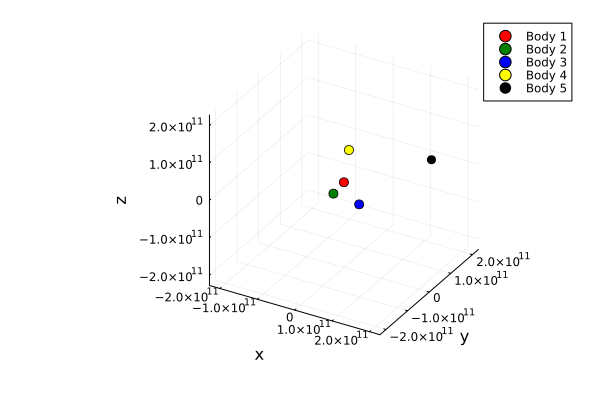

In [7]:
# Plot predicted trajectory of last system over time
include("utils/nbodysystem.jl")
# plotlyjs() # Set the backend to PlotlyJS
println("Number of systems in env: ", length(agent.env.systems))
SYSTEM_IDX = length(agent.env.systems)
anim = plot_trajectory(agent.env.systems[SYSTEM_IDX])
gif(anim, "nbodysystem.gif", fps = 30)

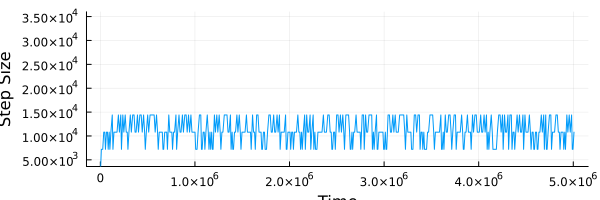

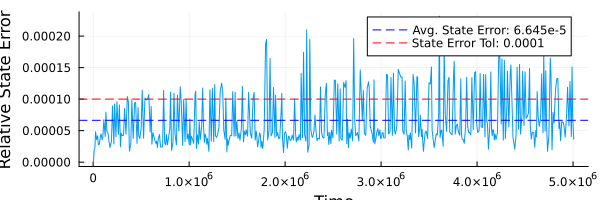

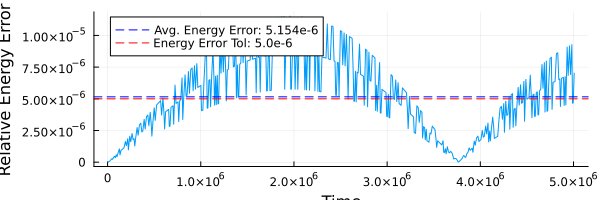

In [8]:
# Plot errors of last system over time
times = agent.env.systems[SYSTEM_IDX].time
true_trajectory = hcat(agent.env.systems[SYSTEM_IDX].true_state...)'
predicted_trajectory = hcat(agent.env.systems[SYSTEM_IDX].estimated_state...)'
energies = [agent.env.systems[SYSTEM_IDX].energy[i] for i in 1:length(times)]
timesteps = [times[i] - times[i-1] for i in 2:length(times)]
state_errors = [norm(true_trajectory[i, :] - predicted_trajectory[i, :]) for i in 1:length(timesteps)]
energy_errors = [abs((energies[i] - energies[i-1]) / energies[i-1]) for i in 2:length(energies)]
state_dim = size(true_trajectory)[2]

# # Plot true trajectory vs predicted trajectory for each dimension
# for i in 1:state_dim
#     plot(times, true_trajectory[:, i], xlabel="Time", ylabel="State Dim $(i)", legend=true, label="True Trajectory", size=(600, 200))
#     display(plot!(times, predicted_trajectory[:, i], label="Predicted Trajectory"))
# end

# Plot timesteps over time
plot(times[2:end], timesteps, xlabel="Time", ylabel="Step Size", legend=false, size=(600, 200))
display(ylims!(agent.env.action_space[1], agent.env.action_space[end]))

# Plot relative state errors over time
plot(times[2:end], state_errors, xlabel="Time", ylabel="Relative State Error", legend=true, size=(600, 200), label=false)
hline!([mean(state_errors)], linecolor=:blue, linestyle=:dash, label = "Avg. State Error: $(round(mean(state_errors), sigdigits = 4))")
# annotate!(times[2], mean(state_errors)*2.5, text("Avg. State Error: $(mean(state_errors))", :left, :top, 10, :blue))
display(hline!([STATE_TOL], linecolor=:red, linestyle=:dash, label = "State Error Tol: $(STATE_TOL)"))

# Plot relative energy error over time
plot(times[2:end], energy_errors, xlabel="Time", ylabel="Relative Energy Error", legend=true, size=(600, 200), label=false)
hline!([mean(energy_errors)], linecolor=:blue, linestyle=:dash, label = "Avg. Energy Error: $(round(mean(energy_errors), sigdigits = 4))")
# annotate!(times[2], mean(energy_errors)*1.4, text("Avg. Energy Error: $(mean(energy_errors))", :left, :top, 10, :blue))
display(hline!([ENERGY_TOL], linecolor=:red, linestyle=:dash, label = "Energy Error Tol: $(ENERGY_TOL)"))

## Function-eval efficiency & time efficiency

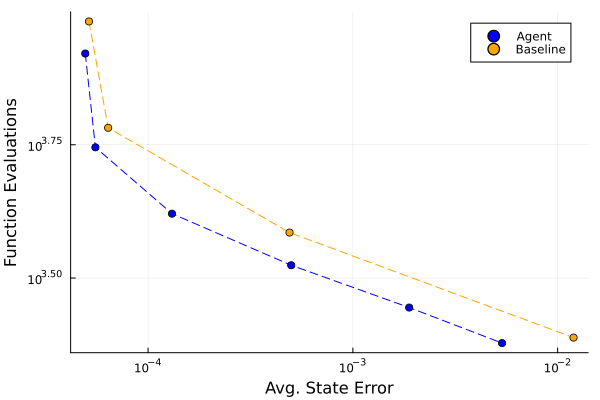

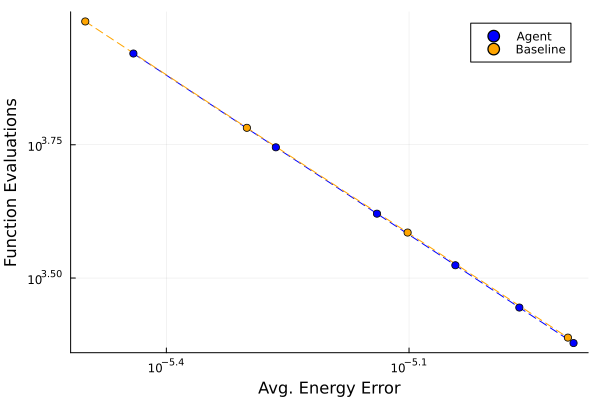

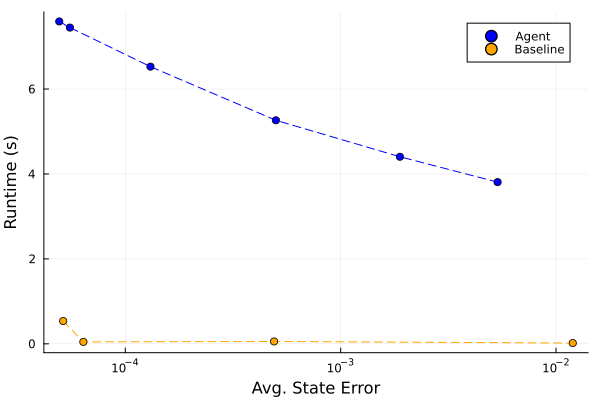

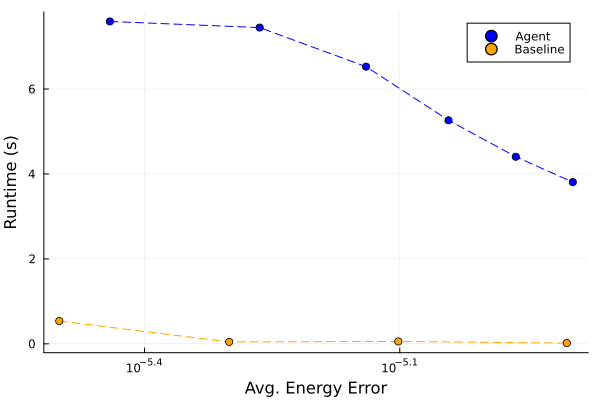

In [9]:
NEW_MAX_TIME = 2 * MAX_TIME

##########################################################################################
# Integrate with agent
new_env = buildNBodyEnvironment(ACTION_SPACE, STATE_TOL, ENERGY_TOL, ALPHA, POS_REWARD_RANGE, NEW_MAX_TIME, METHOD, N_BODIES, GRAVITY)
initial_state = INITIAL_STATE

avg_state_errors_agent = []
avg_energy_errors_agent = []
num_evals_agent = []
runtimes_agent = []
actions_agent = []
for step_boost in [-1, 0, 1, 2, 3, 4]
    # Run to collect stepwise error data
    observation = new_system!(new_env, initial_state)
    state_errors_agent = []
    energy_errors_agent = []
    done = false
    while !done
        action = act(agent, observation, eval_mode = true, step_boost = step_boost)
        next_observation, state_error, energy_error, state_reward, energy_reward, total_reward, done = env_step!(new_env, action)
        push!(actions_agent, ACTION_SPACE[action])
        push!(state_errors_agent, state_error)
        push!(energy_errors_agent, energy_error)
        remember!(agent, observation, action, total_reward, next_observation, done)
        observation = next_observation
    end
    
    # Run again to collect runtime data
    observation = new_system!(new_env, initial_state)
    done = false
    start_time = time()
    while !done
        action = act(agent, observation, eval_mode = true, step_boost = step_boost)
        next_observation, done = env_step_evalmode!(new_env, action)
        push!(actions_agent, ACTION_SPACE[action])
        remember!(agent, observation, action, 0.0, next_observation, done)
        observation = next_observation
    end
    end_time = time()

    # Save data
    push!(runtimes_agent, end_time - start_time)
    push!(avg_state_errors_agent, sum(state_errors_agent) / length(state_errors_agent))
    push!(avg_energy_errors_agent, sum(energy_errors_agent) / length(energy_errors_agent))
    push!(num_evals_agent, length(new_env.systems[end].eval_trace) * (length(new_env.systems[end].eval_trace[1].k)))
end
##########################################################################################
# Integrate with DP5 at different error tolerances
new_system!(new_env, initial_state)
tols = [1e-14, 1e-13, 1e-12, 1e-11]

avg_state_errors_baseline = []
avg_energy_errors_baseline = []
num_evals_baseline = []
runtimes_baseline = []
for tol in tols
    # Integrate at desired tolerance
    start_time = time()
    ODEFunctionWrapper = (u, p, t) -> function_(t, u, new_env.systems[end])
    prob = ODEProblem(ODEFunctionWrapper, new_env.systems[end].true_state[1], (0.0, NEW_MAX_TIME))
    predicted_sol = solve(prob, DP5(), reltol=tol, abstol=tol)
    end_time = time()
    
    # Collect stepwise error data
    state_errors_baseline = []
    energy_errors_baseline = []
    for idx in 1:length(predicted_sol) - 1
        # Get ground truth state at next time step
        prob = ODEProblem(ODEFunctionWrapper, predicted_sol.u[idx, :][1], (predicted_sol.t[idx], predicted_sol.t[idx+1]))
        gt_sol = solve(prob, DP5(), reltol=1e-8)
        ground_truth = gt_sol.u[end]
        predicted = predicted_sol.u[idx+1]
        push!(state_errors_baseline, norm(ground_truth - predicted))
        
        # Get energy at current time step and next time step
        current_energy = get_energy_from_state(predicted_sol.u[idx], new_env.systems[end])
        next_energy = get_energy_from_state(predicted_sol.u[idx+1], new_env.systems[end])
        push!(energy_errors_baseline, abs(next_energy - current_energy) / abs(current_energy))
    end

    # Save data
    push!(runtimes_baseline, end_time - start_time)
    push!(num_evals_baseline, predicted_sol.destats.nf)
    push!(avg_state_errors_baseline, sum(state_errors_baseline) / length(state_errors_baseline))
    push!(avg_energy_errors_baseline, sum(energy_errors_baseline) / length(energy_errors_baseline))
end

##########################################################################################
# Plot function evaluations vs. state errors on a loglog plot
plot(avg_state_errors_agent, num_evals_agent, xlabel="Avg. State Error", ylabel="Function Evaluations", legend=true, xscale=:log10, yscale=:log10, label=false, color=:blue, linestyle=:dash)
plot!(avg_state_errors_baseline, num_evals_baseline, label=false, color=:orange, linestyle=:dash)
scatter!(avg_state_errors_agent, num_evals_agent, label="Agent", color=:blue)
display(scatter!(avg_state_errors_baseline, num_evals_baseline, label="Baseline", color=:orange))

# Plot function evaluations vs. energy errors on a loglog plot
plot(avg_energy_errors_agent, num_evals_agent, xlabel="Avg. Energy Error", ylabel="Function Evaluations", legend=true, xscale=:log10, yscale=:log10, label=false, color=:blue, linestyle=:dash)
plot!(avg_energy_errors_baseline, num_evals_baseline, label=false, color=:orange, linestyle=:dash)
scatter!(avg_energy_errors_agent, num_evals_agent, label="Agent", color=:blue)
display(scatter!(avg_energy_errors_baseline, num_evals_baseline, label="Baseline", color=:orange))

# Plot runtime vs. state errors on a linlog plot
plot(avg_state_errors_agent, runtimes_agent, xlabel="Avg. State Error", ylabel="Runtime (s)", legend=true, xscale=:log10, label=false, color=:blue, linestyle=:dash)
plot!(avg_state_errors_baseline, runtimes_baseline, label=false, color=:orange, linestyle=:dash)
scatter!(avg_state_errors_agent, runtimes_agent, label="Agent", color=:blue)
display(scatter!(avg_state_errors_baseline, runtimes_baseline, label="Baseline", color=:orange))

# Plot runtime vs. energy errors on a linlog plot
plot(avg_energy_errors_agent, runtimes_agent, xlabel="Avg. Energy Error", ylabel="Runtime (s)", legend=true, xscale=:log10, label=false, color=:blue, linestyle=:dash)
plot!(avg_energy_errors_baseline, runtimes_baseline, label=false, color=:orange, linestyle=:dash)
scatter!(avg_energy_errors_agent, runtimes_agent, label="Agent", color=:blue)
display(scatter!(avg_energy_errors_baseline, runtimes_baseline, label="Baseline", color=:orange))